In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from scipy import stats

import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.utils import get_custom_objects
from tensorflow.python.keras import backend as K

In [2]:
def custom_softmax_DG(x):
    beta = 0.01
    xx = beta*x
    e = K.exp(xx-K.max(xx, axis=-1, keepdims=True))
    s = K.sum(e, axis=-1, keepdims=True)
    return e / s

get_custom_objects().update({'custom_softmax_DG': keras.layers.Activation(custom_softmax_DG)})


def custom_softmax_CA3(x):
    beta = 0.1
    xx = beta*x
    e = K.exp(xx-K.max(xx, axis=-1, keepdims=True))
    s = K.sum(e, axis=-1, keepdims=True)
    return e / s

get_custom_objects().update({'custom_softmax_CA3': keras.layers.Activation(custom_softmax_CA3)})


def create_model(n_DG, n_CA3, n_CA1, dim):
    global custom_softmax_DG, custom_softmax_CA3

    model = keras.Sequential([
        keras.layers.Dense(n_DG, activation=tf.nn.relu, input_shape=(dim,), name='DG'),
        #keras.layers.Activation(custom_softmax_DG,name='DG_softmax') ,
        keras.layers.Dense(n_CA3, activation=tf.nn.relu, name='CA3'),
        keras.layers.Activation(custom_softmax_CA3, name='CA3_softmax'),
        keras.layers.Dense(n_CA1, activation=tf.nn.relu, name='CA1'),
        keras.layers.Dense(dim, activation=tf.nn.relu)
    ])

    optimizer = tf.train.RMSPropOptimizer(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


## Callback function is deactivated
def fit(model, data, EPOCHS = 1000, save_weights=True):
    #f_cb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2,
                                         #verbose=0, mode='auto', baseline=None)  # min_delta=0.01, patience=10

    
    ## Shuffle training data
    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)

    ## fit the model
    history = model.fit(data[idx], data[idx], epochs=EPOCHS, validation_split=0.2, verbose=0)#, callbacks=[f_cb])

    if save_weights:
        model.save_weights('model.h5')

    return history

In [3]:
def G_rate_map(arena_size=[100,100], theta=0., phase=[50,50], lamb=500):
    '''
    Grid cells activity maps as presented in:
    - Blair et al. (2007), equation (1)
    - Almeida et al. (2009), equation (1)
    Params:
        arena_size (tuple of int) : define rate_map dimensions
        theta (float)             : Grid rotation (assume to be either 0°, 20°, or 40°, in degrees)
        Phase (tuple of int)      : Spatial phase of the grid     
        lamb (int)                : Distance between firing fields
    '''

    G = np.zeros(arena_size)
    a = 0.3
    b = -3./2.        
    lambV = (4*np.pi)/(np.sqrt(3*lamb))
    theta = np.radians(theta)

    for ind, val in np.ndenumerate(G):

        tmp_g = 0
        for i in np.deg2rad(np.linspace(-30,90,3)):
            u_f = (np.cos(i+theta),np.sin(i+theta))
            dist = (ind[0]-phase[0],ind[1]-phase[1])
            tmp_g += np.cos( lambV * np.dot(u_f,dist) )
            
        tmp_g = np.exp(np.dot(a,(tmp_g)+b))-1
        G[ind] = tmp_g
        
    
    ## Normalize if for learning and LEC integration effiency 
    if G.min()<0: G += abs(G.min())
    G = (G - G.min())/(G.max()-G.min())
        
    return G

In [4]:
# def LEC_rate_map(arena_size=[100,100], filled_perc=0.2):
    
#     '''
#     Build 'sort of' LEC cells. See Renno-Costa et al. 2010
#     These cells have X (filled_perc) number of firing fields randomly spread over the arena
#     Params:
#         arena_size (tuple of int) : define rate_map dimensions
#         filled_perc (float)       : define how much area this cell is receptive to (value from 0 to 1).
#     '''
    
#     a = np.zeros(225)
# #     a = np.random.uniform(0,0.2,225)
#     a[: int(filled_perc*25) ] =   np.random.uniform(0.5,1.0,int(filled_perc*25)) #1
#     np.random.shuffle(a)
#     a = a.reshape(15,15)
    
#     b = np.zeros((arena_size[0], arena_size[1]))
    
#     for i in range(arena_size[0]):
#         for j in range(arena_size[1]):
#             idx1 = i * len(a) / arena_size[0]
#             idx2 = j * len(a) / arena_size[1]
#             b[i][j] = a[idx1][idx2]

#     arena = scipy.ndimage.filters.gaussian_filter(b, 4)
#     arena *= 0.6
    
#     return arena



def LEC_rate_map(arena_size=[100,100]):
    
    n_fields    = np.random.randint(3,7)
    fields_size = [4,7]
    gaus_sigma  = np.random.uniform(2,5)
    
    b = np.zeros((arena_size[0], arena_size[1]))
    
    for nfield in range(n_fields):
        
        idx_x,idx_y = np.random.randint(5,arena_size[0]) , np.random.randint(5,arena_size[1])
        extend_x,extend_y = np.random.randint(7,15) , np.random.randint(7,15)
        b[ idx_x-extend_x:idx_x+extend_x , idx_y-extend_y:idx_y+extend_y  ] = np.random.uniform(0.7,1.)
        
    
    arena = scipy.ndimage.filters.gaussian_filter(b, gaus_sigma)
    arena *= 0.6
    
    return arena

In [5]:
n_grid = 70
n_lec = 230
grid_lamb, grid_phase = [],[]  # this will be used to generate grid cells on the reshaped version of the environment

arena_size = [50,50]


grid_data = []
for ii in range(n_grid):
    lamb  = np.random.randint(500,2000)
    phase = np.random.randint(0,arena_size[0],2)  ## This is assuming arena is a square
    g = G_rate_map(arena_size=arena_size, phase=phase, lamb=lamb)
    
    grid_data.append( g.flatten()  )
    grid_lamb.append(lamb)
    grid_phase.append(phase)

grid_data = np.array(grid_data)


lec_1_data = []
for ii in range(n_lec):
#     l = LEC_rate_map(arena_size=arena_size, filled_perc=0.2)
    l = LEC_rate_map(arena_size=arena_size)
    lec_1_data.append( l.flatten()  )
lec_1_data = np.array(lec_1_data)

In [6]:
# Make data structure combining both MEC and LEC_1
data = np.vstack((grid_data , lec_1_data))
data = data.T

# Build the model

In [7]:
n_DG,n_CA3,n_CA1 = 200,70,100

model = create_model(n_DG=n_DG, n_CA3=n_CA3, n_CA1=n_CA1, dim=n_grid+n_lec)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DG (Dense)                   (None, 200)               60200     
_________________________________________________________________
CA3 (Dense)                  (None, 70)                14070     
_________________________________________________________________
CA3_softmax (Activation)     (None, 70)                0         
_________________________________________________________________
CA1 (Dense)                  (None, 100)               7100      
_________________________________________________________________
dense (Dense)                (None, 300)               30300     
Total params: 111,670
Trainable params: 111,670
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = fit(model, data, EPOCHS = 1000, save_weights=False)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


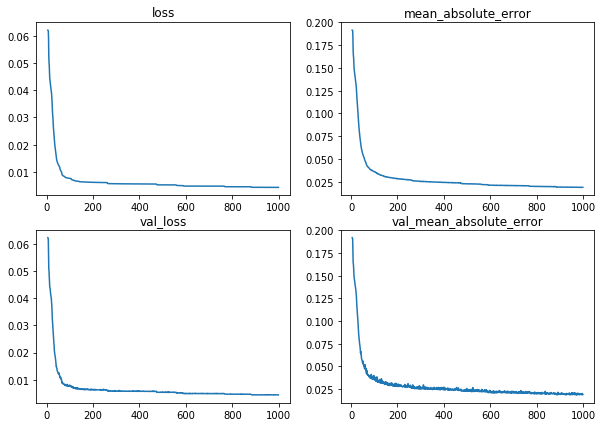

In [9]:
plt.figure(figsize=(10,7),facecolor='white')
counter = 1
for kk in history.history.keys():
    plt.subplot(2,2,counter)
    plt.plot(  history.epoch[5:], history.history[kk][5:] )
    plt.title(kk)
    counter +=1

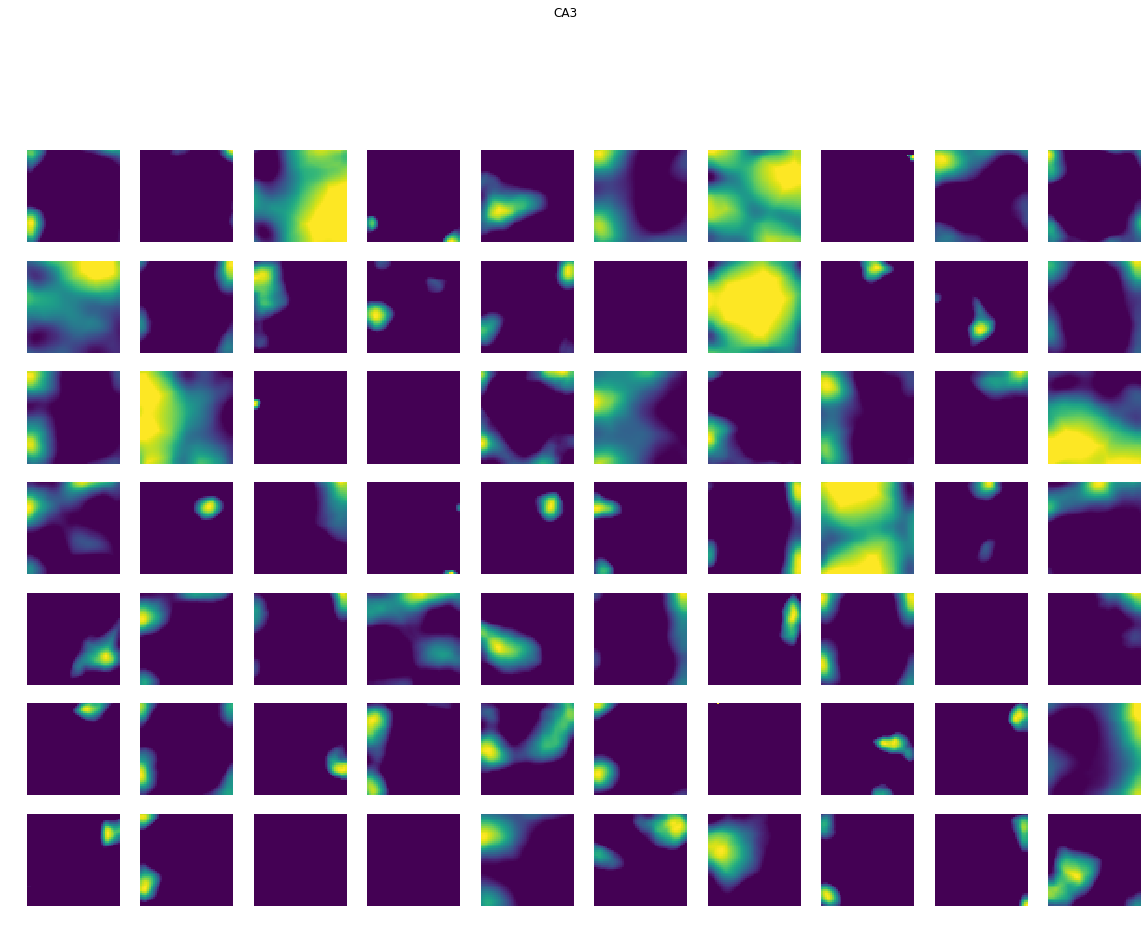

In [10]:
layer_name = 'CA3'
units =  model.get_layer(layer_name).units

heatmaps = np.zeros((units,50,50)) # activations from neurons in SoftMax layer for the whole 50x50 arena
m2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)  # the way to get a layer's output in Keras
for pos in range(data.shape[0]):                  # go through the whole arena
    out = m2.predict(np.array([data[pos]]))       # activate network and get SoftMax outputs
    heatmaps[:, int(pos/50), int(pos%50)] += out.ravel()    # save the outputs

heatmaps -= heatmaps.min(axis=0)
heatmaps /= heatmaps.max(axis=0)

plt.figure(figsize=(20,20),facecolor='white')
plt.suptitle(layer_name)

for ii in range(heatmaps.shape[0]):
    plt.subplot(10,10,ii+1)
    plt.imshow(heatmaps[ii])
#     plt.clim(0,.001)
    plt.axis('off')    

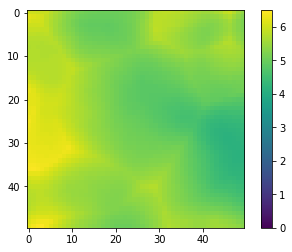

In [11]:
plt.imshow(np.sum(heatmaps,axis=0))
plt.clim(0)
plt.colorbar()

# Rate remapping

### Generate a novel environment and test the PV correlation by progressively changing the amount of LEC cells

In [12]:
## Build a new LEC context (LEC_2)
lec_2_data = []
for ii in range(n_lec):
#     l = LEC_rate_map(arena_size=arena_size, filled_perc=0.2)
    l = LEC_rate_map(arena_size=arena_size)
    lec_2_data.append( l.flatten()  )
lec_2_data = np.array(lec_2_data)

In [13]:
# Make a new data structure combining both MEC and LEC_2
data2 = np.vstack((grid_data , lec_2_data))
data2 = data2.T

{'whiskers': [<matplotlib.lines.Line2D at 0x135f22828>,
 'caps': [<matplotlib.lines.Line2D at 0x135f22eb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x135f22400>],
 'medians': [<matplotlib.lines.Line2D at 0x135f2c588>],
 'fliers': [<matplotlib.lines.Line2D at 0x135f2c8d0>],
 'means': []}

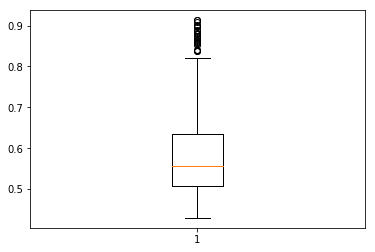

In [14]:
lcor = []
for ii in range( 74, 300):
    lcor.append( stats.pearsonr(data[ii,:],data2[ii,:])[0] )
plt.boxplot(lcor)

# Morphing remapping analysis
#### Let the agent run throughout the arena at multiple morphing conditions (i.e., progressively changing from the LEC1 to LEC2)

In [15]:
log_new_data = []

layer_name = 'CA3_softmax'
# units =  model.get_layer(layer_name).units


add_noise = False  ## Add noise to the input data

all_heat_maps = []

for dd in np.linspace(0,1,7):


    new_data = np.zeros_like(data)

    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)

    print( 'dd:' , int(idx.size*dd) )
    new_data[  idx[ int(idx.size*dd) : ]  ] = data[  idx[ int(idx.size*dd) :] ]
    new_data[  idx[ : int(idx.size*dd) ]  ] = data2[ idx[ : int(idx.size*dd)  ] ]
    
    log_new_data.append( new_data )
    
    if add_noise:
        new_data += np.random.uniform(-new_data.mean()*7, new_data.mean()*7, new_data.shape)
    
    
    ## COMPUTE THE ACTIVATION HEATMAPS FOR SOFTMAX LAYER WHILE NAVIGATING THROUGH THE WHOLE ARENA ###################

    heatmaps = np.zeros((units,50,50))      # activations from neurons in SoftMax layer for the whole 50x50 arena

    m2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)  # the way to get a layer's output in Keras

    for pos in range(data.shape[0]):                  # go through the whole arena

        out = m2.predict(np.array([new_data[pos]]))       # activate network and get SoftMax outputs
        heatmaps[:, int(pos/50), int(pos%50)] += out.ravel()    # save the outputs



    all_heat_maps.append(heatmaps)

dd: 0
dd: 416
dd: 833
dd: 1250
dd: 1666
dd: 2083
dd: 2500


In [16]:
all_heat_maps = np.array(all_heat_maps)

In [17]:
pv_corr = []
pv_diff = []
for i in range(all_heat_maps.shape[0]):
    pv_corr.append( stats.pearsonr( all_heat_maps[0].flatten() , all_heat_maps[i].flatten() )[0] )
    
    
pv_corr = np.array(pv_corr)    

In [18]:
new_heat = np.copy(all_heat_maps.reshape(7,units,50*50))

pv_corr_2 = []

for i in range(new_heat.shape[0]):
    
    tmp_pv_corr_2 = []
    
    for pos in range(new_heat.shape[2]):
    
        tmp_pv_corr_2.append( stats.pearsonr( new_heat[i,:,pos] , new_heat[0,:,pos]  )[0] )
        
    pv_corr_2.append( np.mean(tmp_pv_corr_2) )
    
    
pv_corr_2= np.array(pv_corr_2)

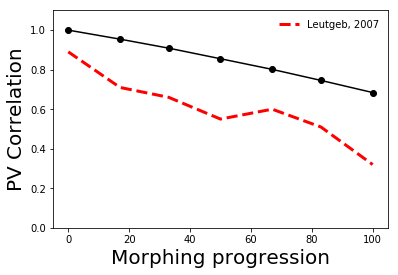

In [19]:
pvcorr_leutgeb = [0.89, 0.71, 0.66, 0.55, 0.6, 0.51, 0.32]
morph_perc = [0, 17,33,50,67,83,100]


# plt.figure(figsize=(6,9))
# 
plt.plot(morph_perc, pv_corr, '-ok')
# plt.plot(morph_perc, pv_corr_2, '-ok', label="Our model")
plt.plot(morph_perc, pvcorr_leutgeb, '--r', linewidth=3, label="Leutgeb, 2007")

plt.ylabel("PV Correlation", fontsize=20)
plt.xlabel("Morphing progression", fontsize=20)

plt.ylim(0,1.1)

plt.legend(frameon=False)

# plt.tight_layout()
# plt.savefig('/Users/diogo/devel/hpc_autoencoder/figures/remapping.jpg', dpi=300)

In [20]:
log_new_data = np.array(log_new_data)

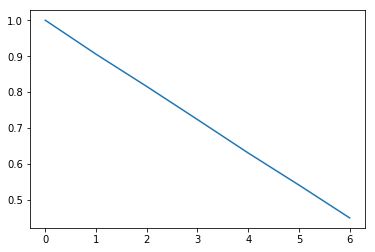

In [21]:
lec_corr = []
for ii in range(7):
    lec_corr.append(stats.pearsonr(log_new_data[0].flatten(), log_new_data[ii].flatten())[0])
plt.plot(lec_corr)

lec_corr = np.array(lec_corr)

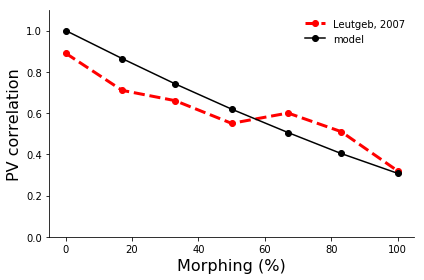

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(morph_perc, pvcorr_leutgeb, '--or', linewidth=3, label="Leutgeb, 2007")
# plt.plot(morph_perc, pv_corr, '-o', color='grey', label='model_pv_corr')
plt.plot(morph_perc, pv_corr*lec_corr, '-ok', label='model')
# plt.plot(morph_perc, lec_corr, '-ok', label='lec_corr')

# plt.title('Rate remapping', fontsize=16)
plt.xlabel('Morphing (%)', fontsize=16)
plt.ylabel('PV correlation', fontsize=16)
plt.legend( frameon=False)

plt.ylim(0,1.1)
plt.tight_layout()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('rate_remapping.png', dpi=400)

# Reshaping the environment (a la Burgess and OKeefe)

In [24]:
https://github.com/DiogoSantosPata/hippocampal_autoencoder.gitn_grid = 70
n_lec = 230

arena_size = [50,100]

grid_data_new = []
for ii in range(n_grid):
    lamb  = grid_lamb[ii]
    phase = grid_phase[ii]
    g = G_rate_map(arena_size=arena_size, phase=phase, lamb=lamb)
    grid_data_new.append( g.flatten()  )
grid_data_new = np.array(grid_data_new)


############################################################################################################
# Data 1 : Stretch LEC fields
lec_new_1_data = []
for ii in range(n_lec):
    l = np.repeat(lec_1_data[ii].reshape(50,50), 2, axis=1)  # Get back the original rate map and stretch it
    lec_new_1_data.append(l.flatten())
lec_new_1_data = np.array(lec_new_1_data)

# Make data structure combining both MEC and LEC_1
data_1 = np.vstack((grid_data_new , lec_new_1_data))
data_1 = data_1.T


############################################################################################################
# Data 2 : Add firing fields to LEC rate maps
lec_new_2_data = []
for ii in range(n_lec):
    l     = LEC_rate_map(arena_size=[50,50])
    old_l = lec_1_data[ii].reshape(50,50)
    this_l = np.hstack((old_l,l))    
    lec_new_2_data.append( this_l.flatten()  )
lec_new_2_data = np.array(lec_new_2_data)


# Make data structure combining both MEC and LEC_1
data_2 = np.vstack((grid_data_new , lec_new_2_data))
data_2 = data_2.T

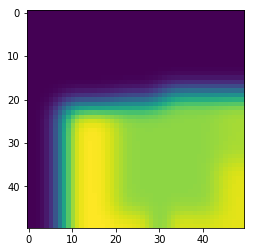

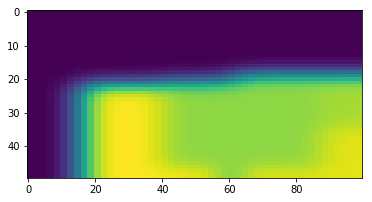

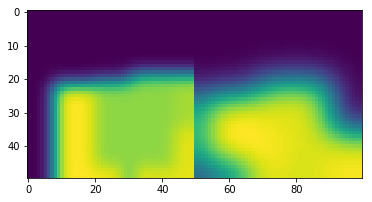

In [25]:
ii = 2
plt.imshow(lec_1_data[ii].reshape(50,50))
plt.show()

plt.imshow(lec_new_1_data[ii].reshape(50,100))
plt.show()

plt.imshow(lec_new_2_data[ii].reshape(50,100))
plt.show()

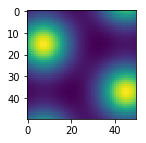

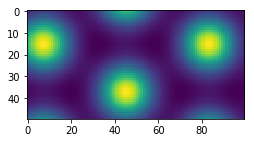

In [26]:
ii = 1

plt.figure(figsize=(2,2))
plt.imshow(grid_data[ii].reshape(50,50))

plt.figure(figsize=(4,2))
plt.imshow(grid_data_new[ii].reshape(50,100))

In [31]:
layer_name = 'CA3'
# units =  model.get_layer(layer_name).units

heatmaps = np.zeros((units,50,50)) # activations from neurons in SoftMax layer for the whole 50x50 arena
m2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)  # the way to get a layer's output in Keras
for pos in range(data.shape[0]):                  # go through the whole arena
    out = m2.predict(np.array([data[pos]]))       # activate network and get SoftMax outputs
    heatmaps[:, int(pos/50), int(pos%50)] += out.ravel()    # save the outputs



heatmaps_1 = np.zeros((units,50,100)) # activations from neurons in SoftMax layer for the whole 50x50 arena
m2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)  # the way to get a layer's output in Keras
for pos in range(data_1.shape[0]):                  # go through the whole arena
    out = m2.predict(np.array([data_1[pos]]))       # activate network and get SoftMax outputs
    heatmaps_1[:, int(pos/100), int(pos%100)] += out.ravel()    # save the outputs
    
    

heatmaps_2 = np.zeros((units,50,100)) # activations from neurons in SoftMax layer for the whole 50x50 arena
m2 = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)  # the way to get a layer's output in Keras
for pos in range(data_2.shape[0]):                  # go through the whole arena
    out = m2.predict(np.array([data_2[pos]]))       # activate network and get SoftMax outputs
    heatmaps_2[:, int(pos/100), int(pos%100)] += out.ravel()    # save the outputs    
    

In [32]:
## CA3

counter = 1
plt.figure(figsize=(30,500))
plt.suptitle("CA3")
for ii in range(heatmaps.shape[0]):
# for ii in range(20):

    plt.subplot(heatmaps.shape[0],3,counter)
    plt.imshow(heatmaps[ii])    
#     plt.axis('off')
    counter += 1
    
    plt.subplot(heatmaps.shape[0],3,counter)
    plt.imshow(heatmaps_1[ii])
#     plt.axis('off')
    counter += 1
    
    plt.subplot(heatmaps.shape[0],3,counter)
    plt.imshow(heatmaps_2[ii])
#     plt.axis('off')
    counter += 1
    
plt.tight_layout()

# plt.savefig('lec_morph.pdf')

In [29]:
### DG


counter = 1
plt.figure(figsize=(30,500))
for ii in range(heatmaps.shape[0]):
# for ii in range(20):

    plt.subplot(heatmaps.shape[0],3,counter)
    plt.imshow(heatmaps[ii])    
#     plt.axis('off')
    counter += 1
    
    plt.subplot(heatmaps.shape[0],3,counter)
    plt.imshow(heatmaps_1[ii])
#     plt.axis('off')
    counter += 1
    
    plt.subplot(heatmaps.shape[0],3,counter)
    plt.imshow(heatmaps_2[ii])
#     plt.axis('off')
    counter += 1
    
plt.tight_layout()

# plt.savefig('lec_morph.pdf')

## Quantify place fields 

In [33]:
def get_number_of_place_fields(ratemap):
    
    gauss_kernel_sigma      = 2.  # px
    active_pixels_threshold = .2 # 20 percent
    cluster_min             = 100#200/3
    cluster_max             = 1000
    
    
#     ratemap = gaussian_filter( ratemap , gauss_kernel_sigma)

    
#     ratemap = (ratemap - ratemap.min()) / ratemap.max()
#     ratemap[ ratemap <  active_pixels_threshold ] = 0
#     ratemap[ ratemap >= active_pixels_threshold ] = 1



    
    ratemap = ratemap-ratemap.min()
    ratemap /= ratemap.max()
        
#     tmp[tmp<active_pixels_threshold] = 0
#     tmp[tmp>=active_pixels_threshold] = 1
    
#     mmmax = ratemap.max()


#     ratemap[ ratemap <  mmmax*active_pixels_threshold ] = 0
#     ratemap[ ratemap >= mmmax*active_pixels_threshold ] = 1


    visited_matrix  = np.zeros_like(ratemap)


    ratemap[ ratemap <  ratemap.max()*active_pixels_threshold ] = 0
    ratemap[ ratemap >= ratemap.max()*active_pixels_threshold ] = 1

    visited_matrix  = np.zeros_like(ratemap)




    ## First pass of clustering
    clusterd_matrix = np.zeros_like(ratemap)
    current_cluster = 1

    #go through every bin in the ratemap
    for yy in range(1,ratemap.shape[0]-1):
        for xx in range(1,ratemap.shape[1]-1):

            if ratemap[  yy, xx ] == 1:

                ## go through every bin around this bin
                for ty in range(-1,2):
                    for tx in range(-1,2):

                        if clusterd_matrix[ yy+ty, xx+tx ] != 0:
                            clusterd_matrix[ yy,xx ] = clusterd_matrix[ yy+ty, xx+tx ]

                if clusterd_matrix[ yy, xx ] == 0:
                    current_cluster += 1
                    clusterd_matrix[ yy, xx ] = current_cluster



    ## Refine clustering: neighbour bins to same cluster number
    for yy in range(1,clusterd_matrix.shape[0]-1):
        for xx in range(1,clusterd_matrix.shape[1]-1):


            if clusterd_matrix[  yy, xx ] != 0:

                ## go through every bin around this bin
                for ty in range(-1,2):
                    for tx in range(-1,2):

                        if clusterd_matrix[ yy+ty, xx+tx ] != 0:
                            if clusterd_matrix[ yy+ty, xx+tx ] != clusterd_matrix[  yy, xx ]:
                                clusterd_matrix[ yy+ty, xx+tx ] = clusterd_matrix[  yy, xx ]







    ## Quantify number of place fields
    clusters_labels = np.delete(np.unique(clusterd_matrix),   np.where(  np.unique(clusterd_matrix) ==0 ) )

    n_place_fields_counter = 0
    
    place_fields_properties = {}

    

    for k in range(clusters_labels.size):

        n_bins = np.where(clusterd_matrix == clusters_labels[k] )[0].size
        
        kluster_index = np.where(clusterd_matrix == clusters_labels[k] )


        if cluster_min <= n_bins <= cluster_max:
            
            
            place_field_center_of_mass = np.mean( kluster_index[0] +1j* kluster_index[1])
            
            place_fields_properties[n_place_fields_counter] = {}
            place_fields_properties[n_place_fields_counter]['size'] = n_bins
            place_fields_properties[n_place_fields_counter]['place_field_center_of_mass'] = place_field_center_of_mass
            

            n_place_fields_counter += 1
            

    return place_fields_properties,clusterd_matrix

In [34]:
p_f_prop = {}
p_f_prop['original']  = []
p_f_prop['stretched'] = []

cluster_matrix = {}
cluster_matrix['original']  = []
cluster_matrix['stretched'] = []


for ii in range(len(heatmaps_1)):
    
    p_f_prop_ori,tmp_clusterd_matrix_ori = get_number_of_place_fields(heatmaps[ii])
    p_f_prop_stre,tmp_clusterd_matrix_stre = get_number_of_place_fields(heatmaps_1[ii])

    
    p_f_prop['original'].append( p_f_prop_ori )
    p_f_prop['stretched'].append( p_f_prop_stre  )
    
    cluster_matrix['original'].append( tmp_clusterd_matrix_ori )
    cluster_matrix['stretched'].append( tmp_clusterd_matrix_stre  )

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater_equal


In [35]:
n_pf_original = []
n_pf_streched = []

for cell_n in range(len(p_f_prop['original'])):

    n_pf_original.append( len(p_f_prop['original'][cell_n].keys()) )
    n_pf_streched.append( len(p_f_prop['stretched'][cell_n].keys()) )

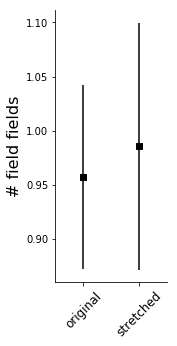

In [36]:
# plt.boxplot([n_pf_original,n_pf_streched], sym='');

fig, ax = plt.subplots(figsize=(2,5))
plt.errorbar( 0, np.nanmean(n_pf_original), yerr=stats.sem(n_pf_original, nan_policy='omit'), marker='s', color='k') 
plt.errorbar( 1, np.nanmean(n_pf_streched), yerr=stats.sem(n_pf_streched, nan_policy='omit'), marker='s', color='k') 
plt.xlim(-.5,1.5)
plt.xticks([0,1], ['original', 'stretched'], rotation=45, fontsize=12)

plt.ylabel('# field fields',fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [37]:
delta_c_o_mass = []
delta_angle = []
delta_abs = []


for cell_n in range(len(p_f_prop['original'])):

    for o_pf_n in range(len(p_f_prop['original'][cell_n])):
        
        for s_pf_n in range(len(p_f_prop['stretched'][cell_n])):
            tmp_delta_c_o_mass = p_f_prop['original'][cell_n][o_pf_n]['place_field_center_of_mass'] - p_f_prop['stretched'][cell_n][s_pf_n]['place_field_center_of_mass']
            tmp_angle = np.angle(p_f_prop['original'][cell_n][o_pf_n]['place_field_center_of_mass'] - p_f_prop['stretched'][cell_n][s_pf_n]['place_field_center_of_mass'])
            tmp_abs = np.abs(p_f_prop['original'][cell_n][o_pf_n]['place_field_center_of_mass'] - p_f_prop['stretched'][cell_n][s_pf_n]['place_field_center_of_mass'])
        
            if abs(tmp_delta_c_o_mass.real) < 20:
                delta_c_o_mass.append(tmp_delta_c_o_mass.real)
                delta_angle.append(tmp_angle)
                delta_abs.append( tmp_abs )
                
delta_abs = np.array(delta_abs)
delta_angle = np.array(delta_angle)
delta_c_o_mass = np.array(delta_c_o_mass)

Text(0.5, 1.0, 'Place field center of mass \n shift horizontal axis (pixels)')

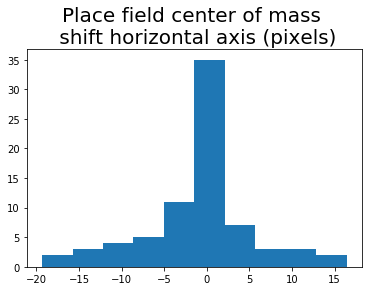

In [38]:
plt.hist(delta_c_o_mass);
# plt.xlim(-16,16)
plt.title('Place field center of mass \n shift horizontal axis (pixels)', fontsize=20)

Text(0.5, 1.1, 'Angular displacement')

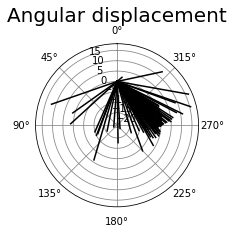

In [39]:
fig = plt.figure(figsize=(3, 3))  # Size
ax = plt.subplot(111, polar=True)  # Create subplot
plt.grid(color='#888888')  # Color the grid
ax.set_theta_zero_location('N')  # Set zero to North

for w in range(len(delta_angle)):
    ax.plot((0, delta_angle[w]), ( 0, delta_c_o_mass[w]), c='k' )
    
plt.title('Angular displacement', fontsize=20, y=1.1)

Text(0.5, 1.0, 'Place field center of mass \n shift both axis (pixels)')

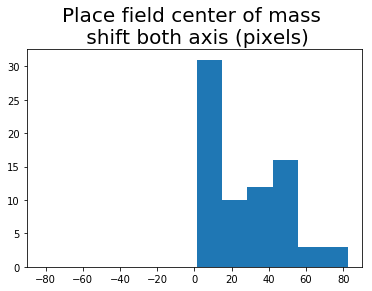

In [43]:
plt.hist(delta_abs,6);
plt.xlim(-90,90)
plt.title('Place field center of mass \n shift both axis (pixels)', fontsize=20)

In [48]:
orig_field_size = []
stre_field_size = []

for cell_n in range(len(p_f_prop['original'])):

    tmp_size = []
    for o_pf_n in range(len(p_f_prop['original'][cell_n])):
        tmp_size.append(  p_f_prop['original'][cell_n][o_pf_n]['size']  )    
    orig_field_size.append( np.mean(tmp_size) )
        
    tmp_size = []
    for s_pf_n in range(len(p_f_prop['stretched'][cell_n])):
        tmp_size.append(  p_f_prop['stretched'][cell_n][s_pf_n]['size']  )    
    stre_field_size.append( np.mean(tmp_size) )            

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


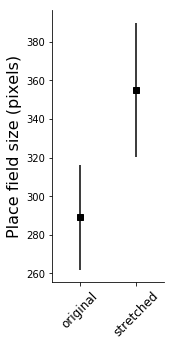

In [49]:
fig, ax = plt.subplots(figsize=(2,5))
plt.errorbar( 0, np.nanmean(orig_field_size), yerr=stats.sem(orig_field_size, nan_policy='omit'), marker='s', color='k') 
plt.errorbar( 1, np.nanmean(stre_field_size), yerr=stats.sem(stre_field_size, nan_policy='omit'), marker='s', color='k') 
plt.xlim(-.5,1.5)
plt.xticks([0,1], ['original', 'stretched'], rotation=45, fontsize=12)

plt.ylabel('Place field size (pixels)',fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
